In [1]:
import os
from resources.utils import scrape_html
import re
import pandas as pd
from tqdm import tqdm

In [2]:
corpus_path = "./corpus"
filepath = os.path.join(corpus_path, os.listdir(corpus_path)[86])
print(filepath)
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

res = scrape_html(filepath)
res

./corpus\23032150.N03.html
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


['בבית המשפט העליון בשבתו כבית משפט\r\n  גבוה לצדק',
 'בג"ץ',
 '3215/23',
 'לפני:',
 "כבוד השופט ד' מינץ",
 "כבוד השופטת י' וילנר",
 "כבוד השופטת ג' כנפי-שטייניץ",
 'העותר:',
 'וליד חאלד עלי',
 'נ',
 'ג',
 'ד',
 'המשיבים:',
 '1. שופט צבאי משפטאי',
 '2. המפקד הצבאי איו"ש',
 '3. שירות הביטחון הכללי',
 'עתירה למתן צו על תנאי',
 'תאריך הישיבה:',
 'כ"א בתמוז התשפ"ג (10.7.2023)',
 'בשם העותר:',
 'עו"ד אשרף אבו סנינה ',
 'בשם המשיבים:',
 'עו"ד נועה רוזנברג ',
 'פסק-דין',
 'העותר יליד 1971,\r\nתושב אסכאכא קלקיליה, נעצר במעצר מינהלי ביום 22.7.2022. מעצרו הוארך לאחרונה עד\r\nליום 20.7.2023 לטענת העותר אין בסיס בדין למעצרו ומאז מעצרו לא נתקבלה הפללה\r\nלחובתו. ',
 'מנגד\r\nלטענת המשיבים, כפי שמופיע בפרפרזה הגלויה שצוינה בתגובתם, כי העותר פעיל מעורב\r\nבקידום פעילות חמא"ס עדכנית ומעצרו נדרש לשם שמירה על ביטחון האזור. אף נמסר\r\nכי בכוונת גורמי הבטחון להמליץ על הארכת מעצר העותר למשך 6 חודשים נוספים.',
 'עיינו בהסכמת ב"כ העותר בחומר הביטחוני הסודי המתייחס לעותר\r\nבמעמד צד אחד והגענו לכלל מסקנה כי י

# **Preparing the data (2)**

In [3]:
def get_judges(parsed_sentences,parsed_tags,html_txt):
    judges = []
    seen_judge = False
    for index,txt in enumerate(html_txt):
        if seen_judge:
            if re.search(":$",txt):
                parsed_sentences.append(txt.split(" "))
                parsed_tags.append(['O']*len(txt.split(" ")))
                return judges,index+1

        if re.search("^כבוד",txt):
            seen_judge = True
            parsed_sentences.append([txt])
            judges.append(txt)
            parsed_tags.append(['Jugde'])
        else:
            parsed_sentences.append(txt.split(" "))
            parsed_tags.append(['O']*len(txt.split(" ")))


def get_prosecutors(parsed_sentences,parsed_tags,index,html_txt):
    prosecutors = []
    while(html_txt[index]!='נ' and html_txt[index]!='נ ג ד') :
        prosecutor = ''.join([i for i in html_txt[index] if not i.isdigit() and i!='.'])
        prosecutors.append(prosecutor)
        parsed_sentences.append([prosecutor])
        parsed_tags.append(['Prosecutor'])
        index+=1
    parsed_sentences.append([html_txt[index]])
    parsed_tags.append(['O'])
    return prosecutors,index+4


def get_defendants(parsed_sentences,parsed_tags,index,html_txt):
    defendants = []
    if not re.search("^[1-9].",html_txt[index]):
        defendant = ''.join([i for i in html_txt[index] if not i.isdigit() and i!='.'])
        defendants.append(defendant)
        parsed_sentences.append([defendant])
        parsed_tags.append(['Defendant'])
        return defendants,index+1

    while(re.search("^[1-9].",html_txt[index])):
        defendant = ''.join([i for i in html_txt[index] if not i.isdigit() and i!='.'])
        defendants.append(defendant)
        parsed_sentences.append([defendant])
        parsed_tags.append(['Defendant'])
        index +=1

    return defendants,index

def get_date(parsed_sentences,parsed_tags,index,html_txt):
    while(not re.search("\u200f[0-9]+[.][0-9]+[.][0-9][0-9]+",html_txt[index]) and ('תאריך הישיבה:' not in html_txt[index]) and ('ניתן היום' not in html_txt[index])):
        parsed_sentences.append(html_txt[index].split(" "))
        parsed_tags.append(['O']*len(html_txt[index].split(" ")))
        index += 1
        if index==len(html_txt):
            return None
    if re.search("\u200f[1-9][0-9]*[.][1-9][0-9]*[.][0-9][0-9]+",html_txt[index]):
        string = re.search("\u200f[1-9][0-9]*[.][1-9][0-9]*[.][0-9][0-9]+",html_txt[index])
        if string:
            parsed_sentences.append([string])
            parsed_tags.append(['Date'])
            return string[0].replace("\u200f","")
        else:
            return None
    elif 'תאריך הישיבה:' in html_txt[index] or 'ניתן היום' in html_txt[index]:
        while(not re.search("[1-9][0-9]*[.][1-9][0-9]*[.][0-9][0-9]+",html_txt[index])):
            parsed_sentences.append(html_txt[index].split(" "))
            parsed_tags.append(['O']*len(html_txt[index].split(" ")))
            index += 1
            if index==len(html_txt):
                return None

        parsed_sentences.append([re.search("[1-9][0-9]*[.][1-9][0-9]*[.][0-9][0-9]+",html_txt[index])[0]])
        parsed_tags.append(['Date'])
        return re.search("[1-9][0-9]*[.][1-9][0-9]*[.][0-9][0-9]+",html_txt[index])[0]
    else:
        return None

In [4]:
judges = []
prosecutors = []
defendants = []
dates = []
parsed_sentences = []
parsed_tags = []

for i,file in enumerate(os.listdir(corpus_path)):
    filepath = os.path.join(corpus_path, os.listdir(corpus_path)[i])
    res = scrape_html(filepath)
    judges_index = get_judges(parsed_sentences,parsed_tags,res)
    judges.append(judges_index[0])
    prosecutors_index = get_prosecutors(parsed_sentences,parsed_tags,judges_index[1],res)
    prosecutors.append(prosecutors_index[0])
    defendants_index = get_defendants(parsed_sentences,parsed_tags,prosecutors_index[1],res)
    defendants.append(defendants_index[0])
    date = get_date(parsed_sentences,parsed_tags,defendants_index[1],res)
    dates.append(date)

500it [00:15, 32.44it/s]


In [5]:
df = pd.DataFrame(list(zip(judges, prosecutors,defendants,dates)),
               columns =['Judges', 'Prosecutors','Defendants','Dates'])
df

,Judges,Prosecutors,Defendants,Dates
0,"[כבוד השופט ד' מינץ, כבוד השופט י' אלרון, כבוד...",[אגודת מגן דוד אדום בישראל],"[ שר התקשורת, \r\n הועדה הבין-משרדית להקצאת מ...",21.11.2022
1,"[כבוד השופט נ' סולברג, כבוד השופטת י' וילנר, כ...","[פלוני, המערער בע""פ /, פלוני]",[מדינת],12.7.2023
2,"[כבוד השופט ד' מינץ, כבוד השופט א' שטיין, כבוד...","[חרסה סטודיו יצרני כלים סניטריים\r\n בע""מ]","[ עו""ד ליאון אמיראס – מנהל מיוחד, הממונה על ח...",16.7.2023
3,[כבוד הרשמת ליאור משאלי שלומאי],"[פלאפון תקשורת בע""מ]",[מדינת ישראל -משרד התקשורת],16.7.2023
4,"[כבוד השופט נ' סולברג, כבוד השופטת ג' כנפי-שטי...","[ עמותת באמנתו יחיה, שמעון זילבר, אליהו טאפל...","[ מפקד תחנת משטרה לב הבירה, מפכ""ל משטרת ישראל...",16.7.2023
...,...,...,...,...
495,"[כבוד השופט י' עמית, כבוד השופט ד' מינץ, כבוד ...",[יאסר אבראהים בדרסאוי],"[ שופט צבאי משפטאי, המפקד הצבאי איו""ש, שירות...",1.6.2023
496,"[כבוד המשנה לנשיאה ע' פוגלמן, כבוד השופט י' אל...",[לואי חמודה חמאיל],"[ שופט צבאי משפטאי, המפקד הצבאי איו""ש, שירות...",1.6.2023
497,"[כבוד השופט י' עמית, כבוד השופטת ד' ברק-ארז, כ...","[המערערות בעע""מ /:, שירותי בריאות כללית, חנה ...",[מתייצבת להליך:],17.4.2023
498,"[כבוד השופט י' אלרון, כבוד השופטת י' וילנר, כב...",[- פלונים],"[ מדינת ישראל, ועדת המאוימים (מת""ק חברון), ה...",1.6.2023


In [6]:
#df.to_excel("/content/DB_2.xlsx",index=False)

# **Training the Dataframe (6)**

In [7]:
sentences = [item for sublist in parsed_sentences for item in sublist]
tags = [item for sublist in parsed_tags for item in sublist]

train_df = pd.DataFrame(list(zip(sentences,tags)),
               columns =['Sentences', 'Tag'])
train_df.tail(30)

,Sentences,Tag
186145,גזר,O
186146,דינו\r\n,O
186147,,O
186148,של,O
186149,בית,O
186150,המשפט,O
186151,המחוזי,O
186152,בתל,O
186153,אביב-יפו,O
186154,"ב-תפ""ח",O


In [8]:
train_df['Tag'].value_counts()

O             182224
Jugde           1413
Defendant       1225
Prosecutor       813
Date             500
Name: Tag, dtype: int64

In [9]:
words = list(set(train_df["Sentences"].values))
tags = list(set(train_df["Tag"].values))
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [10]:
import tqdm
import numpy as np


def sentence_integrate(data):
  agg_func = lambda s: [(w, t) for w, t in zip(s["Sentences"].values.tolist(),
                                                           s["Tag"].values.tolist())]
  return data.groupby(np.arange(len(data.index))//50, axis=0).apply(agg_func).tolist()

In [11]:
sentences=sentence_integrate(train_df)

In [14]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 50

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=len(words)-1)

y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

In [15]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [16]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM,Embedding
from tensorflow.keras.layers import InputLayer, SpatialDropout1D, Bidirectional

In [17]:
num_words = len(words)

In [18]:
model = keras.Sequential()
model.add(InputLayer((max_len)))
model.add(Embedding(input_dim=num_words+1, output_dim=max_len, input_length=max_len))
model.add(SpatialDropout1D(0.1))
model.add(Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1)))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 50)            2164600   
                                                                 
 spatial_dropout1d (SpatialD  (None, 50, 50)           0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 50, 200)          120800    
 l)                                                              
                                                                 
Total params: 2,285,400
Trainable params: 2,285,400
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [20]:
!pip install livelossplot

In [21]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback
import tensorflow as tf

from livelossplot import PlotLossesKeras
from tqdm import tqdm
from keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau

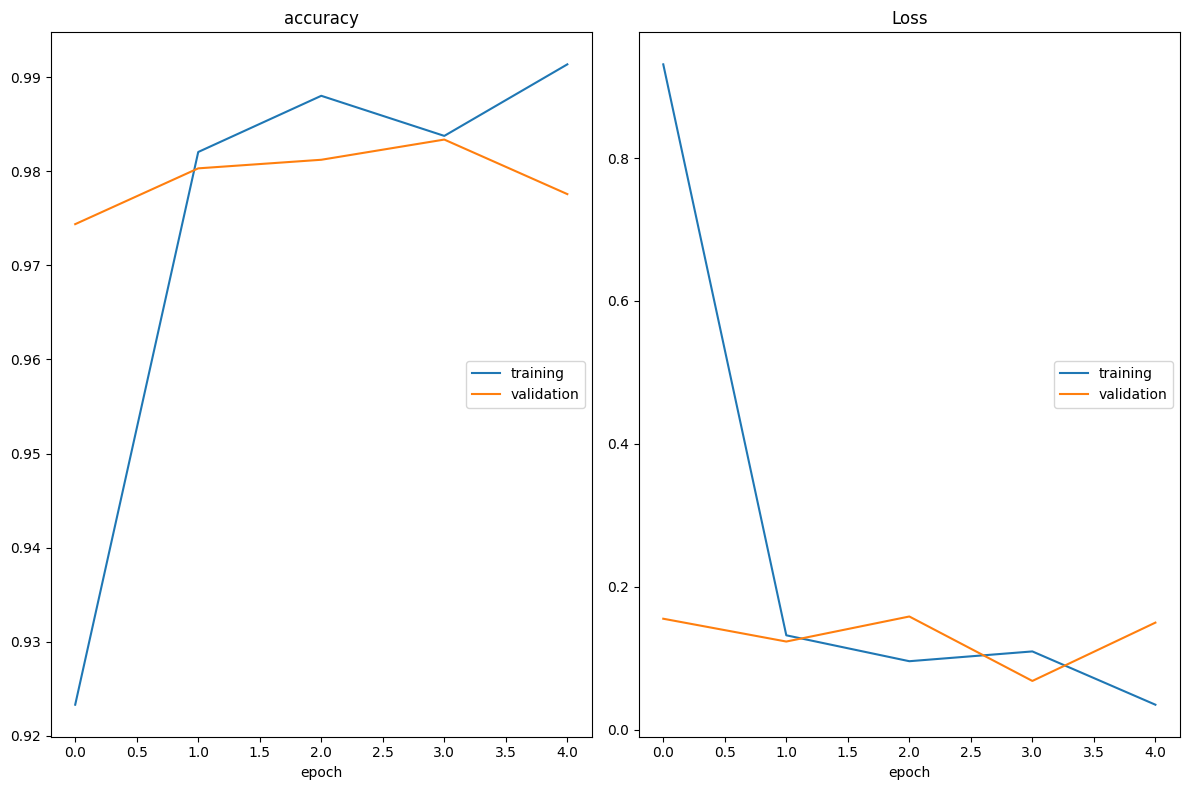

accuracy
	training         	 (min:    0.923, max:    0.991, cur:    0.991)
	validation       	 (min:    0.974, max:    0.983, cur:    0.978)
Loss
	training         	 (min:    0.035, max:    0.931, cur:    0.035)
	validation       	 (min:    0.068, max:    0.158, cur:    0.150)
94/94 [==============================] - 13s 136ms/step - loss: 0.0349 - accuracy: 0.9914 - val_loss: 0.1498 - val_accuracy: 0.9776
CPU times: user 1min 49s, sys: 2.8 s, total: 1min 52s
Wall time: 1min 15s


In [22]:
%%time

early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=1, verbose=0, mode='max', baseline=None, restore_best_weights=False)

callbacks = [PlotLossesCallback(), early_stopping]

history = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_test,y_test),
    batch_size=32,
    epochs=5,
    callbacks=callbacks,
    verbose=1
)


In [23]:
print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=128)
print("test loss: {} ".format(results[0]))
print("test accuracy: {} ".format(results[1]))

Evaluate on test data
6/6 [==============================] - 0s 52ms/step - loss: 0.1498 - accuracy: 0.9776
test loss: 0.14978687465190887 
test accuracy: 0.9775838851928711 


# **(2) VS (6)**

In [28]:
i = 35
print("This is sentence:",i)
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)

print("{:25}{:5}\t {}\n".format("Word", "True (סעיף 2)", "Pred (סעיף 6)"))
print("-" *50)
for w, true, pred in zip(x_test[i], y_test[i], p[0]):
    print("{:30}{:5}\t{}".format(words[w-1], tags[true], tags[pred]))

This is sentence: 35
1/1 [==============================] - 0s 20ms/step
Word                     True (סעיף 2)	 Pred (סעיף 6)

--------------------------------------------------
שאין                          O    	O
הבדלים                        O    	O
מהותיים
בין                   O    	O
מבנים                         O    	O
אלו                           O    	O
למבנים                        O    	O
מושא                          O    	O
העתירה.                       O    	O
                              O    	O
רביעית                        O    	O
,                             O    	O
                              O    	O
טוענים                        O    	O
העותרים                       O    	O
כי                            O    	O
נפל                           O    	O
שיהוי                         O    	O
רב                            O    	O
בהוצאת
צווי                   O    	O
ההריסה                        O    	O
מושא                          O    	O
העתירה                 

In [25]:
i = 35
print("This is sentence:",i)
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)

print("{:25}{:5}\t {}\n".format("Word", "True (סעיף 2)", "Pred (סעיף 6)"))
print("-" *50)
for w, true, pred in zip(x_test[i], y_test[i], p[0]):
    print("{:30}{:5}\t{}".format(words[w-1], tags[true], tags[pred]))

This is sentence: 35
1/1 [==============================] - 0s 22ms/step
Word                     True (סעיף 2)	 Pred (סעיף 6)

--------------------------------------------------
שאין                          O    	O
הבדלים                        O    	O
מהותיים
בין                   O    	O
מבנים                         O    	O
אלו                           O    	O
למבנים                        O    	O
מושא                          O    	O
העתירה.                       O    	O
                              O    	O
רביעית                        O    	O
,                             O    	O
                              O    	O
טוענים                        O    	O
העותרים                       O    	O
כי                            O    	O
נפל                           O    	O
שיהוי                         O    	O
רב                            O    	O
בהוצאת
צווי                   O    	O
ההריסה                        O    	O
מושא                          O    	O
העתירה                 